### Import Library


In [27]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objs as go

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

import json
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline


## Load Dataset


In [28]:
df_train = pd.read_csv("data/Housing_dataset_train.csv")
df_train.drop('ID', axis=1, inplace=True)
print(df_train.shape)
df_train.head(3)


(14000, 6)


,loc,title,bedroom,bathroom,parking_space,price
0,Katsina,Semi-detached duplex,2.0,2.0,1.0,1149999.565
1,Ondo,Apartment,NaN,2.0,4.0,1672416.689
2,Ekiti,NaN,7.0,5.0,NaN,3364799.814


In [29]:
df_test = pd.read_csv("data/Housing_dataset_test.csv")
df_test.drop('ID', axis=1, inplace=True)
print(df_test.shape)
df_test.head()


(6000, 5)


,loc,title,bedroom,bathroom,parking_space
0,Kano,Penthouse,4,1,2
1,Adamawa,Apartment,2,2,4
2,Adamawa,Bungalow,2,7,2
3,Lagos,Mansion,9,5,2
4,Gombe,Semi-detached duplex,5,6,1


In [30]:
df_test["price"] = "test"


In [31]:
# join test and train data
df = pd.concat([df_train, df_test], axis=0, sort=False)
df.head()


,loc,title,bedroom,bathroom,parking_space,price
0,Katsina,Semi-detached duplex,2.0,2.0,1.0,1149999.565
1,Ondo,Apartment,NaN,2.0,4.0,1672416.689
2,Ekiti,NaN,7.0,5.0,NaN,3364799.814
3,Anambra,Detached duplex,5.0,2.0,4.0,2410306.756
4,Kogi,Terrace duplex,NaN,5.0,6.0,2600700.898


In [32]:
df.shape


(20000, 6)

In [33]:
df.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 20000 entries, 0 to 5999
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   loc            18187 non-null  object 
 1   title          18278 non-null  object 
 2   bedroom        18201 non-null  float64
 3   bathroom       18195 non-null  float64
 4   parking_space  18189 non-null  float64
 5   price          20000 non-null  object 
dtypes: float64(3), object(3)
memory usage: 1.1+ MB


### Feature Engineering

- Group `loc` (states) intpo regions 
- Calculate bedroom-bathroom ratio
- Rank `title` by highest average price 

In [34]:
with open("state_to_region.json", "r") as f:
    state_to_region = json.load(f)

# create a new column that maps states to regions
df["region"] = df["loc"].map(state_to_region)
df.head()

,loc,title,bedroom,bathroom,parking_space,price,region
0,Katsina,Semi-detached duplex,2.0,2.0,1.0,1149999.565,North West
1,Ondo,Apartment,NaN,2.0,4.0,1672416.689,South West
2,Ekiti,NaN,7.0,5.0,NaN,3364799.814,South West
3,Anambra,Detached duplex,5.0,2.0,4.0,2410306.756,South East
4,Kogi,Terrace duplex,NaN,5.0,6.0,2600700.898,North Central


In [35]:
df["bed_bath_ratio"] = df["bedroom"] / df["bathroom"]
df.head()

,loc,title,bedroom,bathroom,parking_space,price,region,bed_bath_ratio
0,Katsina,Semi-detached duplex,2.0,2.0,1.0,1149999.565,North West,1.0
1,Ondo,Apartment,NaN,2.0,4.0,1672416.689,South West,NaN
2,Ekiti,NaN,7.0,5.0,NaN,3364799.814,South West,1.4
3,Anambra,Detached duplex,5.0,2.0,4.0,2410306.756,South East,2.5
4,Kogi,Terrace duplex,NaN,5.0,6.0,2600700.898,North Central,NaN


In [36]:
# group the data by 'title' and calculate the mean price for each group
title_mean_prices = df_train.groupby("title")["price"].mean()

# sort the groups by mean price in descending order
title_mean_prices_sorted = title_mean_prices.sort_values(ascending=False)

# assign ranks to the groups based on their order
title_ranks = title_mean_prices_sorted.rank(method="dense").astype(int)

title_ranks

title
Mansion                 10
Penthouse                9
Detached duplex          8
Townhouse                7
Terrace duplex           6
Semi-detached duplex     5
Bungalow                 4
Flat                     3
Apartment                2
Cottage                  1
Name: price, dtype: int64

In [37]:
# create a new column 'title_rank' that contains the ranks of the 'title' column
df['title_rank'] = df['title'].map(title_ranks)

In [38]:
df.drop('title', axis=1, inplace=True)

In [39]:
# remove the 'price' column from df and save it to a variable
price_col = df.pop('price')

# insert the 'price' column back into df at the last position
df.insert(len(df.columns), 'price', price_col)

df.head()

,loc,bedroom,bathroom,parking_space,region,bed_bath_ratio,title_rank,price
0,Katsina,2.0,2.0,1.0,North West,1.0,5.0,1149999.565
1,Ondo,NaN,2.0,4.0,South West,NaN,2.0,1672416.689
2,Ekiti,7.0,5.0,NaN,South West,1.4,NaN,3364799.814
3,Anambra,5.0,2.0,4.0,South East,2.5,8.0,2410306.756
4,Kogi,NaN,5.0,6.0,North Central,NaN,6.0,2600700.898


### Check for missing Values


In [40]:
df_train.isna().sum()

loc              1813
title            1722
bedroom          1799
bathroom         1805
parking_space    1811
price               0
dtype: int64

In [41]:
df.isna().sum()


loc               1813
bedroom           1799
bathroom          1805
parking_space     1811
region            1813
bed_bath_ratio    3531
title_rank        1722
price                0
dtype: int64

## Data Preprocessing

### Train-test split

In [42]:
# Divide the dataframe into train and test based on the 'price' column
df_train = df[~df["price"].astype(str).str.contains("test")]
df_test = df[df["price"].astype(str).str.contains("test")]

# Reset the index of the dataframes
df_train = df_train.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)


### Label Encoding

### Filling all missing values


In [43]:
print(df_train['parking_space'].mode()[0])
print(df_test['parking_space'].mode()[0])
print(df['parking_space'].mode()[0])

4.0
2.0
2.0


In [44]:
df_train.isna().sum() / len(df_train) * 100


loc               12.950000
bedroom           12.850000
bathroom          12.892857
parking_space     12.935714
region            12.950000
bed_bath_ratio    25.221429
title_rank        12.300000
price              0.000000
dtype: float64

In [45]:
from sklearn.impute import SimpleImputer

imp_mode = SimpleImputer(missing_values=np.nan, strategy="most_frequent")
imp_mode.fit(df_train)

df_train = pd.DataFrame(imp_mode.transform(df_train), columns=df.columns)
df_test = pd.DataFrame(imp_mode.transform(df_test), columns=df.columns)


In [46]:
df_train.dtypes

loc               object
bedroom           object
bathroom          object
parking_space     object
region            object
bed_bath_ratio    object
title_rank        object
price             object
dtype: object

In [20]:
print(df_train.isna().sum())
print(df_test.isna().sum())

loc               0
title             0
bedroom           0
bathroom          0
parking_space     0
region            0
bed_bath_ratio    0
title_rank        0
price             0
dtype: int64
loc               0
title             0
bedroom           0
bathroom          0
parking_space     0
region            0
bed_bath_ratio    0
title_rank        0
price             0
dtype: int64


In [54]:
df_train.head()

,loc,bedroom,bathroom,parking_space,region,bed_bath_ratio,title_rank,price
0,Katsina,2.0,2.0,1.0,North West,1.0,5.0,1149999.565
1,Ondo,5.0,2.0,4.0,South West,1.0,2.0,1672416.689
2,Ekiti,7.0,5.0,4.0,South West,1.4,3.0,3364799.814
3,Anambra,5.0,2.0,4.0,South East,2.5,8.0,2410306.756
4,Kogi,5.0,5.0,6.0,North Central,1.0,6.0,2600700.898


In [22]:
# df["bedroom"] = df["bedroom"].fillna(df["bedroom"].mode()[0])
# df["bathroom"] = df["bathroom"].fillna(df["bathroom"].mode()[0])
# df["parking_space"] = df["parking_space"].fillna(df["parking_space"].mode()[0])
# df["loc"] = df["loc"].fillna(df["loc"].mode()[0])
# df["title"] = df["title"].fillna(df["title"].mode()[0])


### Label Encoding

In [55]:
le = LabelEncoder()

# encode location amd title
for col in ["loc", "region"]:
    le = le.fit(df_train[col])
    df_train[col] = le.transform(df_train[col])
    df_test[col] = le.transform(df_test[col])
df_train.head()

,loc,bedroom,bathroom,parking_space,region,bed_bath_ratio,title_rank,price
0,19,2.0,2.0,1.0,2,1.0,5.0,1149999.565
1,27,5.0,2.0,4.0,5,1.0,2.0,1672416.689
2,12,7.0,5.0,4.0,5,1.4,3.0,3364799.814
3,3,5.0,2.0,4.0,3,2.5,8.0,2410306.756
4,21,5.0,5.0,6.0,0,1.0,6.0,2600700.898


In [24]:
df_test.head()

,loc,title,bedroom,bathroom,parking_space,region,bed_bath_ratio,title_rank,price
0,18,6,4.0,1.0,2.0,2,4.0,9.0,test
1,1,0,2.0,2.0,4.0,1,1.0,2.0,test
2,1,1,2.0,7.0,2.0,1,0.285714,4.0,test
3,23,5,9.0,5.0,2.0,5,1.8,10.0,test
4,14,7,5.0,6.0,1.0,1,0.833333,5.0,test


## Model

In [25]:
print(df_train.shape, df_test.shape)


(14000, 9) (6000, 9)


### Scaling of dataset


In [56]:
X = df_train.drop("price", axis=1)
y = df_train["price"].astype(float)
X_test = df_test.drop("price", axis=1)
y_test = df_test["price"]


In [57]:
# scale the dataset with standard scaler

scaler = StandardScaler()
train_scaler = scaler.fit(X)
X = train_scaler.transform(X)
# scaler.fit(X_test)
X_test = train_scaler.transform(X_test)


In [58]:
x_cols = df_train.columns[0:-1]
print(x_cols)
X = pd.DataFrame(X, columns=x_cols)
X.head()

Index(['loc', 'bedroom', 'bathroom', 'parking_space', 'region',
       'bed_bath_ratio', 'title_rank'],
      dtype='object')


,loc,bedroom,bathroom,parking_space,region,bed_bath_ratio,title_rank
0,0.163812,-1.046498,-0.423135,-1.500034,-0.251603,-0.484095,-0.169590
1,0.990773,0.263223,-0.423135,0.476110,1.626030,-0.484095,-1.279746
2,-0.559779,1.136369,1.054513,0.476110,1.626030,-0.223131,-0.909694
3,-1.490110,0.263223,-0.423135,0.476110,0.374275,0.494520,0.940567
4,0.370552,0.263223,1.054513,1.793539,-1.503358,-0.484095,0.200463


In [29]:
# split dataset

from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=7)

print(X_train.shape, X_val.shape)
print(y_train.shape, y_val.shape)


(10500, 8) (3500, 8)
(10500,) (3500,)


### Model Creation


In [30]:
def fit_score(model, X, y):
    X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=7)
    
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    
    rmse = round(mean_squared_error(y_val, y_pred, squared=False))
    print(f"RMSE: {rmse:,}")
    
    model.fit(X,y)
    return model

### RandomForestRegressor

In [32]:
# Create a linear regression model
from sklearn.ensemble import RandomForestRegressor

In [33]:
rf_model = fit_score(RandomForestRegressor(), X, y)
predictions = rf_model.predict(X_test)

RMSE: 609,517


In [31]:
sample_sub = pd.read_csv('data/Sample_submission.csv')
print(sample_sub.shape)
sample_sub.head()

(6000, 1)


,ID
0,845
1,1924
2,10718
3,12076
4,12254


In [68]:
sample_sub['price'] = predictions
sample_sub.to_csv('submissions/rf_regression_sub.csv', index=False)
sample_sub.head()

,ID,price
0,845,2.395405e+06
1,1924,1.038551e+06
2,10718,1.357044e+06
3,12076,8.007182e+06
4,12254,1.974406e+06


### Model Evaluation


we evaluate the performance of the regression model by visually inspecting the predicted values and comparing them to the actual values in the training data since theres no test data.
This will create a scatter plot of the predicted values versus the actual values in the training data.
A good regression model will have the predicted values close to the actual values along the diagonal line.


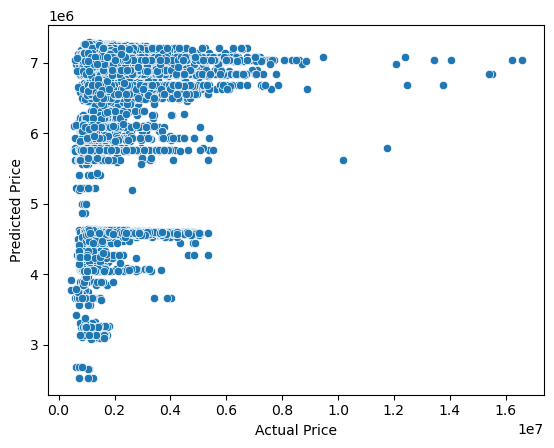

In [34]:
# Create a scatter plot of the predicted vs actual values
sns.scatterplot(x=df_train["price"], y=rf_model.predict(df_train.drop("price", axis=1)))
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.show() 


### Improving model performance


### Ridge regularization


In [70]:
from sklearn.linear_model import Ridge

# Create a Ridge regression model with a regularization strength of 0.1
model = Ridge(alpha=0.1)

# Fit the model to the training data
model.fit(X_train, y_train)

# Predict the target variable for the test data
y_pred = model.predict(X_val)

# Calculate the RMSE of the model on the validation data
rmse = round(mean_squared_error(y_val, y_pred, squared=False))
print(f"RMSE: {rmse:,}")


RMSE: 919,332


### hyper parameter tuning


In [71]:
# Define the hyperparameters to tune
# param_grid = {
#     "ridge__alpha": [0.1, 1, 10, 100],
#     "ridge__fit_intercept": [True, False],
#     "polynomialfeatures__degree": [1, 2, 3],
# }

# # Create a Ridge regression model
# model = make_pipeline(PolynomialFeatures(), Ridge())

# # Create a grid search object
# grid_search = GridSearchCV(model, param_grid, cv=5, scoring="neg_root_mean_squared_error")

# # Fit the grid search object to the training data
# grid_search.fit(X_train, y_train)

# # Print the best hyperparameters and the corresponding score
# print("Best hyperparameters:", grid_search.best_params_)
# print("Best score:", f"{-grid_search.best_score_:,.0f}")


In [72]:
# # Create a Ridge regression model with the best hyperparameters
# model = make_pipeline(
#     PolynomialFeatures(degree=grid_search.best_params_["polynomialfeatures__degree"]),
#     Ridge(
#         alpha=grid_search.best_params_["ridge__alpha"],
#         fit_intercept=grid_search.best_params_["ridge__fit_intercept"],
#     ),
# )

# # Train the model on the entire training set
# model.fit(X_train, y_train)

# # Make predictions on the test set
# y_pred = model.predict(X_val)

# # Calculate the RMSE of the model on the test set
# rmse = mean_squared_error(y_val, y_pred, squared=False)

# print("RMSE:", f"{rmse:,.0f}")


### GradientBoostingRegressor

In [35]:
from sklearn.ensemble import GradientBoostingRegressor

gb_model = fit_score(GradientBoostingRegressor(random_state=42), X, y)

RMSE: 549,329


### Hyperparemeter tuning

In [36]:
# # Define the hyperparameters to tune
# param_grid = {
#     "n_estimators": [100, 200, 300],
#     "max_depth": [3, 5, 7],
#     "learning_rate": [0.01, 0.1, 1],
# }

# # Create a Gradient Boosting model
# model = GradientBoostingRegressor()

# # Create a GridSearchCV object
# grid_search = GridSearchCV(
#     model, param_grid, cv=5, scoring="neg_root_mean_squared_error", n_jobs=-1
# )

# # Fit the GridSearchCV object to the training data
# grid_search.fit(X_train, y_train)

# # Print the best hyperparameters and the corresponding RMSE score
# print("Best hyperparameters:", grid_search.best_params_)
# print("RMSE score:", f"{ -grid_search.best_score_:,.0f}")

In [37]:
# Define the hyperparameters to tune
param_grid = {
    "n_estimators": [150, 200, 125],
    "max_depth": [4, 5, 6],
    "learning_rate": [0.01, 0.1, 1],
}

# Create a Gradient Boosting model
model = GradientBoostingRegressor()

# Create a GridSearchCV object
grid_search = GridSearchCV(
    model, param_grid, cv=10, scoring="neg_root_mean_squared_error", n_jobs=-1
)

# Fit the GridSearchCV object to the training data
grid_search.fit(X_train, y_train)

# Print the best hyperparameters and the corresponding RMSE score
print("Best hyperparameters:", grid_search.best_params_)
print("RMSE score:", f"{ -grid_search.best_score_:,.0f}")

Best hyperparameters: {'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 150}
RMSE score: 542,796


In [77]:
# def fn(**grid_search.best_params_):
#     return grid_search.best_params_

In [40]:
gb_model = fit_score(
    GradientBoostingRegressor(random_state=42, **grid_search.best_params_), X, y
)


RMSE: 537,421


In [41]:
predictions = gb_model.predict(X_test)

sample_sub['price'] = predictions
sample_sub.to_csv('submissions/gb_regressor_tuned_feat_engineering.csv', index=False)
sample_sub.head()

# 362891.4090 on LB
# 358028.1369 on LB with feature engeneering


,ID,price
0,845,2.335170e+06
1,1924,9.771873e+05
2,10718,1.208809e+06
3,12076,9.056497e+06
4,12254,1.874817e+06


### KFold Cross Validation Gradient Boosting Regressor

In [44]:
gbr = GradientBoostingRegressor(random_state=4220, **grid_search.best_params_)

In [45]:
# from sklearn.model_selection import KFold

# rmse_list = []
# test_preds = []

# # create a StratifiedKFold object
# kf = KFold(n_splits=10, shuffle=True, random_state=200)

# # create a GradientBoostingRegressor object


# # iterate over the folds
# for i, (train_index, val_index) in enumerate(kf.split(X, y)):
#     # split the data into training and valing sets
#     X_train, X_val = X[train_index], X[val_index]
#     y_train, y_val = y[train_index], y[val_index]

#     # fit the model on the training data
#     gbr.fit(X_train, y_train)

#     y_pred = gbr.predict(X_val)

#     # evaluate the model on the validation data
#     rmse = mean_squared_error(y_val, y_pred, squared=False)
#     rmse_list.append(rmse)

#     # print the score for each fold
#     print(f"Fold {i+1} RMSE: {rmse:,.0f}")
#     print("=======" * 10)

#     preds = gbr.predict(X_test)
#     test_preds.append(preds)

# print(f"Average RMSE: {np.mean(rmse_list):,.0f}")

In [68]:
from sklearn.model_selection import KFold
from typing import List, Callable

sns.set(style="darkgrid")


def fold_fit_score(
    model,
    X: pd.DataFrame,
    y: pd.Series,
    n_folds: int,
    transform_func: Callable,
    inverse_transform_func: Callable,
    plot_feat_imp=False,
) -> List[list]:
    rmse_list_transformed = []
    test_preds_transformed = []

    # create a StratifiedKFold object
    kf = KFold(n_splits=n_folds, shuffle=True, random_state=20)

    # iterate over the folds
    for i, (train_index, val_index) in enumerate(kf.split(X, y)):
        # split the data into training and valing sets
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = transform_func(y[train_index].astype(float)), y[val_index]

        # fit the model on the training data
        model.fit(X_train, y_train)

        y_pred = model.predict(X_val)

        # evaluate the model on the validation data
        rmse = mean_squared_error(y_val, inverse_transform_func(y_pred), squared=False)
        rmse_list_transformed.append(rmse)

        # print the score for each fold
        print(f"Fold {i+1} RMSE: {rmse:,.0f}")
        print("=======" * 10)

        preds = model.predict(X_test)
        test_preds_transformed.append(inverse_transform_func(preds))

    print(f"Average RMSE: {np.mean(rmse_list_transformed):,.0f}")

    if plot_feat_imp:
        # feature importance plot for model
        feat_imp = pd.DataFrame(
            {"Feature": X.columns, "Importance": model.feature_importances_}
        )
        feat_imp = feat_imp.sort_values(by="Importance", ascending=False).reset_index(
            drop=True
        )
        plt.figure(figsize=(10, 8))
        sns.barplot(x="Importance", y="Feature", data=feat_imp)
        plt.title(f"Feature Importance for {type(model).__name__}")
        plt.show()

    return test_preds_transformed

Fold 1 RMSE: 478,509
Fold 2 RMSE: 413,078
Fold 3 RMSE: 598,088
Fold 4 RMSE: 469,592
Fold 5 RMSE: 708,021
Fold 6 RMSE: 490,800
Fold 7 RMSE: 506,013
Fold 8 RMSE: 553,900
Fold 9 RMSE: 610,759
Fold 10 RMSE: 633,652
Fold 11 RMSE: 477,879
Fold 12 RMSE: 606,643
Fold 13 RMSE: 476,420
Fold 14 RMSE: 475,316
Fold 15 RMSE: 683,765
Average RMSE: 545,496


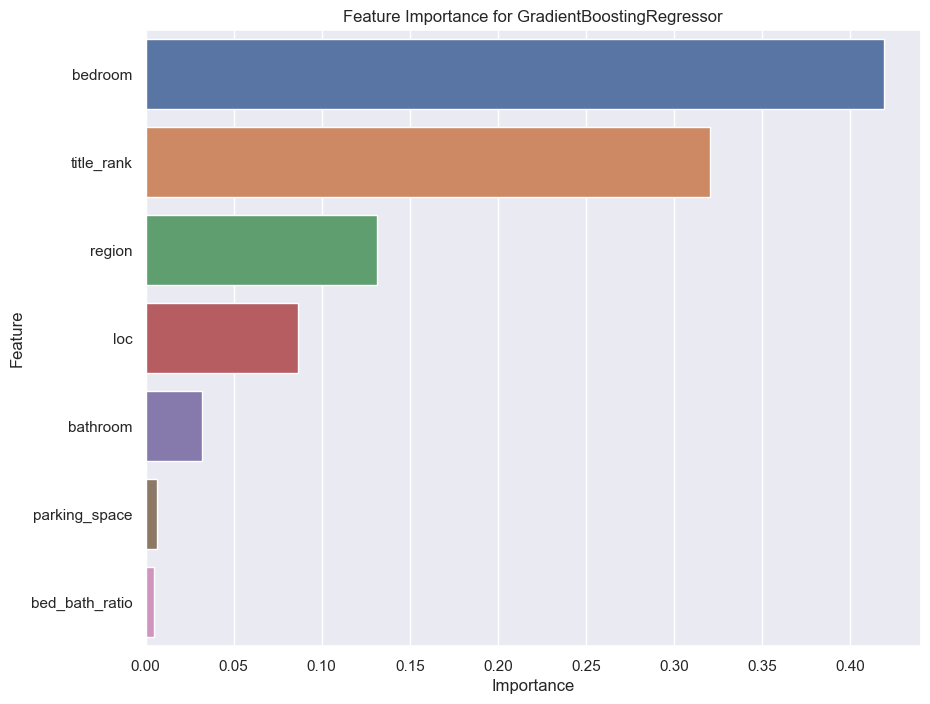

In [77]:
gbr_preds = fold_fit_score(
    gbr,
    X,
    y,
    15,
    transform_func=np.log1p,
    inverse_transform_func=np.expm1,
    plot_feat_imp=True,
)

# 543,978

In [71]:
gbr_preds[0]

array([2301717.17925198, 1002790.24698098, 1271937.24527206, ...,
       2074485.4389203 , 1697706.35096222, 3488121.85616951])

In [72]:
sample_sub["price"] = np.mean(gbr_preds, axis=0)
sample_sub.to_csv(
    "submissions/gb_regressor_tuned_kfold_15_sqrt_transformed_feat_eng.csv", index=False
)
sample_sub.head()

# LB Score: 344462.8593
# LB Score: 346061.0930 with sqrt transformation


,ID,price
0,845,2.285318e+06
1,1924,1.016355e+06
2,10718,1.238927e+06
3,12076,8.885165e+06
4,12254,1.826053e+06


### CatBoostRegressor

Fold 1 RMSE: 495,032
Fold 2 RMSE: 416,099
Fold 3 RMSE: 583,445
Fold 4 RMSE: 461,724
Fold 5 RMSE: 710,396
Fold 6 RMSE: 486,502
Fold 7 RMSE: 500,443
Fold 8 RMSE: 561,403
Fold 9 RMSE: 620,617
Fold 10 RMSE: 637,708
Fold 11 RMSE: 474,128
Fold 12 RMSE: 606,004
Fold 13 RMSE: 466,947
Fold 14 RMSE: 473,833
Fold 15 RMSE: 680,747
Average RMSE: 545,002


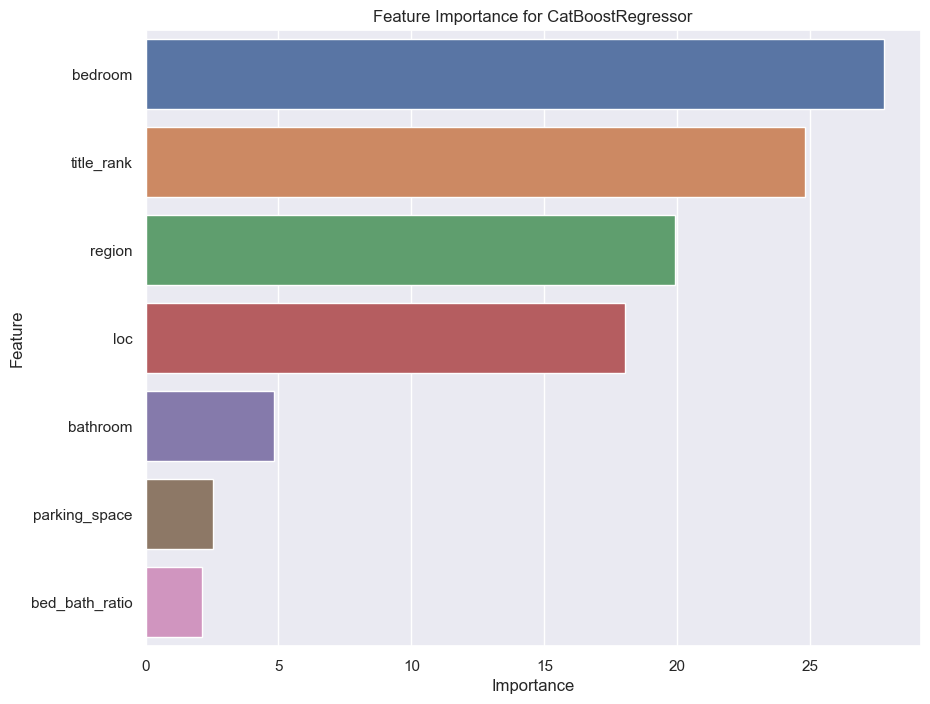

In [78]:
from catboost import CatBoostRegressor

cb = CatBoostRegressor(
    loss_function="RMSE",
    random_seed=419,
    verbose=False,
)

cb_preds = fold_fit_score(
    cb,
    X,
    y,
    15,
    transform_func=np.log1p,
    inverse_transform_func=np.expm1,
    plot_feat_imp=True,
)

In [74]:
sample_sub['price'] = np.mean(cb_preds, axis=0)
sample_sub.to_csv('submissions/catboost_regressor_kfold_15_sqrt_transformed_feat_eng.csv', index=False)
sample_sub.head()

# LB Score: 370764.5299

,ID,price
0,845,2.392023e+06
1,1924,1.069272e+06
2,10718,1.224225e+06
3,12076,8.872981e+06
4,12254,1.839018e+06


Fold 1 RMSE: 486,773
Fold 2 RMSE: 415,899
Fold 3 RMSE: 589,673
Fold 4 RMSE: 471,539
Fold 5 RMSE: 704,003
Fold 6 RMSE: 489,031
Fold 7 RMSE: 502,358
Fold 8 RMSE: 558,769
Fold 9 RMSE: 615,405
Fold 10 RMSE: 636,448
Fold 11 RMSE: 473,217
Fold 12 RMSE: 603,160
Fold 13 RMSE: 470,375
Fold 14 RMSE: 476,275
Fold 15 RMSE: 666,489
Average RMSE: 543,961


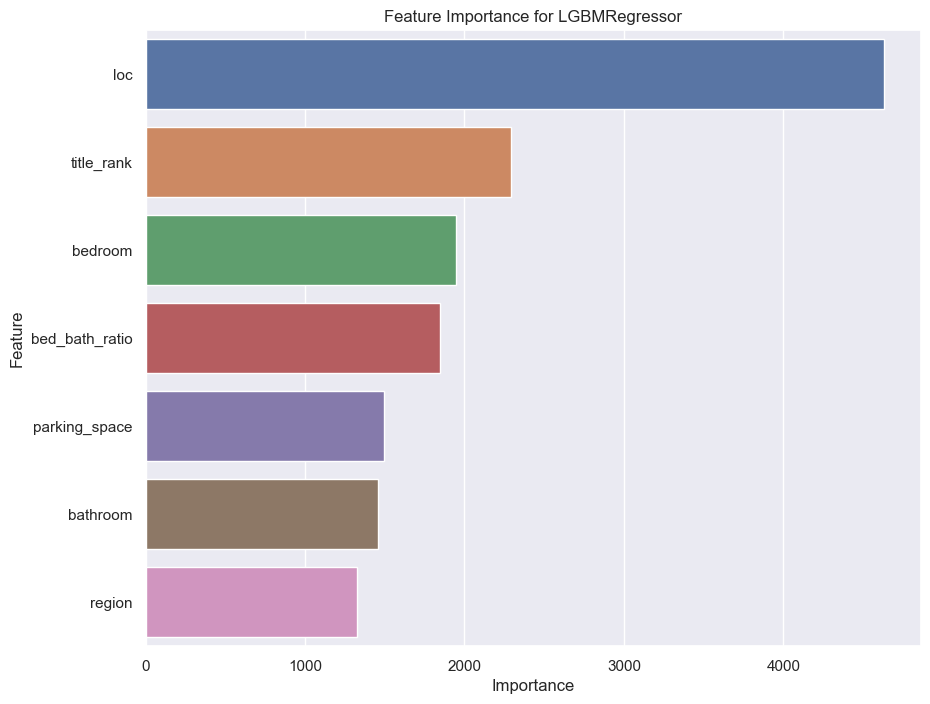

In [79]:
from lightgbm import LGBMRegressor

params = {
    "n_estimators": 500,
    "colsample_bytree": 0.86,
    "learning_rate": 0.032,
    "max_depth": 7,
    "subsample": 0.85,
}

lgbm_reg = LGBMRegressor(**params, random_state=2023, objective="rmse", verbosity=-1)

lgbm_preds = fold_fit_score(
    lgbm_reg,
    X,
    y,
    15,
    transform_func=np.log1p,
    inverse_transform_func=np.expm1,
    plot_feat_imp=True,
)

In [76]:
sample_sub['price'] = np.mean(lgbm_preds, axis=0)
sample_sub.to_csv('submissions/lgbm_regressor_kfold_15_sqrt_transformed_feat_eng.csv', index=False)
sample_sub.head()

,ID,price
0,845,2.338481e+06
1,1924,1.065296e+06
2,10718,1.200931e+06
3,12076,8.532945e+06
4,12254,1.881348e+06


In [82]:
# 0.45 * gb_preds + 0.35 * lgbm_preds + 0.2 * cb_preds

sample_sub["price"] = (
    0.45 * np.mean(gbr_preds, axis=0)
    + 0.35 * np.mean(lgbm_preds, axis=0)
    + 0.2 * np.mean(cb_preds, axis=0)
)

sample_sub.to_csv("submissions/ensemble.csv", index=False)
sample_sub.head()

,ID,price
0,845,2.340911e+06
1,1924,1.042749e+06
2,10718,1.227455e+06
3,12076,9.137489e+06
4,12254,1.813196e+06


In [76]:
# from sklearn.preprocessing import PolynomialFeatures

# # Create polynomial features
# poly = PolynomialFeatures(degree=4)
# X_train_poly = poly.fit_transform(X_train)
# X_val_poly = poly.transform(X_val)

# # Define the hyperparameters to tune
# param_grid = {
#     "n_estimators": [150, 200, 125],
#     "max_depth": [4, 5, 6],
#     "learning_rate": [0.01, 0.1, 1],
# }

# # Create a Gradient Boosting model
# model = GradientBoostingRegressor()

# # Create a GridSearchCV object
# grid_search = GridSearchCV(
#     model, param_grid, cv=5, scoring="neg_root_mean_squared_error", n_jobs=-1
# )

# # Fit the GridSearchCV object to the training data
# grid_search.fit(X_train_poly, y_train)

# # Print the best hyperparameters and the corresponding RMSE score
# print("Best hyperparameters:", grid_search.best_params_)
# print("RMSE score:", -grid_search.best_score_)

### Cross Validation

In [80]:
from sklearn.ensemble import GradientBoostingRegressor, BaggingRegressor
from sklearn.preprocessing import PolynomialFeatures

# Create polynomial features
poly = PolynomialFeatures(degree=2)
X_train_poly = poly.fit_transform(X_train)
X_val_poly = poly.transform(X_val)

# Create a Gradient Boosting model
model = GradientBoostingRegressor()

# Create a BaggingRegressor model with the Gradient Boosting model as the base estimator
bagging_model = BaggingRegressor(base_estimator=model, n_estimators=10)

# Fit the model to the training data
bagging_model.fit(X_train_poly, y_train)

# Predict the target variable for the test data
y_pred = bagging_model.predict(X_val_poly)


In [81]:
mean_squared_error(y_val, y_pred, squared=False)

561734.8952800276